## Simple graph example

In [1]:
import numpy as np

# simple computational graph - numpy
N, D = 3, 4
np.random.seed(0)
x = np.random.randn(N, D)
y = np.random.randn(N, D)
z = np.random.randn(N, D)

a = x * y  # shape (N, D)
b = a + z  # shape (N, D)
c = np.sum(b)

grad_c = 1.0
grad_b = grad_c * np.ones((N,D))
grad_a = grad_b.copy()
grad_z = grad_b.copy()
grad_x = grad_a * y
grad_y = grad_a * x

print(c)
print(grad_x)
print(grad_y)
print(grad_z)

6.717008537800067
[[ 0.76103773  0.12167502  0.44386323  0.33367433]
 [ 1.49407907 -0.20515826  0.3130677  -0.85409574]
 [-2.55298982  0.6536186   0.8644362  -0.74216502]]
[[ 1.76405235  0.40015721  0.97873798  2.2408932 ]
 [ 1.86755799 -0.97727788  0.95008842 -0.15135721]
 [-0.10321885  0.4105985   0.14404357  1.45427351]]
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]


In [2]:
#TENSORFLOW 2.0
import numpy as np
import tensorflow as tf

# simple computational graph with tensorflow

@tf.function # this decorator tells tf that a graph is defined
def simple_graph(x, y, z):
    a = x * y
    b = a + z
    c = tf.reduce_sum(input_tensor=b)
    grad_x, grad_y, grad_z = tf.gradients(ys=c, xs=[x, y, z])
    return c, grad_x, grad_y, grad_z

N, D = 3, 4
np.random.seed(0)
x = np.random.randn(N, D)
y = np.random.randn(N, D)
z = np.random.randn(N, D)

c_val, grad_x_val, grad_y_val, grad_z_val = simple_graph(x, y, z)

print('c_val =', c_val)
print('grad_x_val =', grad_x_val)
print('grad_y_val =', grad_y_val)
print('grad_z_val =', grad_z_val)

c_val = tf.Tensor(6.717008537800066, shape=(), dtype=float64)
grad_x_val = tf.Tensor(
[[ 0.76103773  0.12167502  0.44386323  0.33367433]
 [ 1.49407907 -0.20515826  0.3130677  -0.85409574]
 [-2.55298982  0.6536186   0.8644362  -0.74216502]], shape=(3, 4), dtype=float64)
grad_y_val = tf.Tensor(
[[ 1.76405235  0.40015721  0.97873798  2.2408932 ]
 [ 1.86755799 -0.97727788  0.95008842 -0.15135721]
 [-0.10321885  0.4105985   0.14404357  1.45427351]], shape=(3, 4), dtype=float64)
grad_z_val = tf.Tensor(
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]], shape=(3, 4), dtype=float64)


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Num GPUs Available:  0
Num CPUs Available:  1


In [4]:
# Just as example to show how it looks in PyTorch 
# You can skip this cell if you don't want to install PyTorch
import torch
from torch.autograd import Variable

# simple computational graph - torch on gpu
N, D = 3, 4

x = Variable(torch.randn(N, D).cuda(), 
             requires_grad=True)
y = Variable(torch.randn(N, D).cuda(), 
             requires_grad=True)
z = Variable(torch.randn(N, D).cuda(), 
             requires_grad=True)

a = x * y
b = a + z
c = torch.sum(b)

c.backward()

print(x.grad.data)
print(y.grad.data)
print(z.grad.data)

ModuleNotFoundError: No module named 'torch'

## A more complex example of graph

### Utility function - plot history

In [5]:
import matplotlib.pyplot as plt

def plot_history(epoch_vector, losses_list, name_list, y_label):
    # plt.figure(figsize=(12,8))
    for i, losses in enumerate(losses_list):
        plt.plot(epoch_vector, losses, label=name_list[i])
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

### Step 0: get some data

In [6]:
# First get MNIST data and prepare it
mnist = tf.keras.datasets.mnist
(x_train, y_train_vec),(x_test, y_test_vec) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train_vec, 10, dtype='float64')
y_test = tf.keras.utils.to_categorical(y_test_vec, 10, dtype='float64')
N = x_train.shape[0]         # number of samples
D = x_train.shape[1]         # dimension of input sample
n_classes = y_train.shape[1] # output dim
print('MNIST data set ready. N={}, D={}, n_classes={}'.format(N,D,n_classes))

11493376/11490434 [==============================] - 1s 0us/step
MNIST data set ready. N=60000, D=784, n_classes=10


### Step 1
This graph is actually creating the necessary nodes to:
1. Do the forward pass (line 8)
2. Compute the MSE loss (lines 9 and 10)
3. Compute the gradients of the loss w.r.t. the weights (line 11)

In line 20, we init the weights (outside of the graph, using numpy). In line 23 we use the graph, passing the whole train set (inputs and targets) and getting out of the graph the predicted outputs, the loss and the gradient values.

In [7]:
# TensorFlow 2.0 - a more complex example
# step 1 - forward pass on single layer ANN with ReLu
import numpy as np
import tensorflow as tf

@tf.function # this decorator tells tf that a graph is defined
def simple_ann_train(x, w1, y):
    y_pred = tf.maximum(tf.matmul(x, w1), 0) # ReLU on logit
    diff = y_pred - y
    loss = tf.reduce_mean(tf.pow(diff, 2))
    grad = tf.gradients(ys=loss, xs=[w1]) 
    # tf.gradients returns a list of sum(dy/dx) for each x in xs
    return y_pred, loss, grad

N = x_train.shape[0]         # number of samples
D = x_train.shape[1]         # dimension of input sample
n_classes = y_train.shape[1] # output dim

np.random.seed(0)
w1 = np.random.randn(D, n_classes)

with tf.device('/CPU:0'):  # change to /GPU:0 to move to GPU
    out = simple_ann_train(x_train, w1, y_train)

y_pred, loss_val, grad = out
grad_w1 = grad[0] #grad is a list
print(loss_val)
print(grad_w1)

tf.Tensor(39.41829141530692, shape=(), dtype=float64)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(784, 10), dtype=float64)


epoch = 0, loss = 39.41829141530692
epoch = 1, loss = 36.043206025440234
epoch = 2, loss = 33.07253170080303
epoch = 3, loss = 30.449656869080798
epoch = 4, loss = 28.126550481355917
epoch = 5, loss = 26.062252351413335
epoch = 6, loss = 24.22200368150052
epoch = 7, loss = 22.576233836528324
epoch = 8, loss = 21.099890233069484
epoch = 9, loss = 19.771455229132886
epoch = 10, loss = 18.572468533193316
epoch = 11, loss = 17.48702518995156
epoch = 12, loss = 16.50171232729688
epoch = 13, loss = 15.604799659289315
epoch = 14, loss = 14.786151227174917
epoch = 15, loss = 14.037002733276523
epoch = 16, loss = 13.34972877544156
epoch = 17, loss = 12.717700387907456
epoch = 18, loss = 12.135166114045061
epoch = 19, loss = 11.597026390657618
epoch = 20, loss = 11.098884763768165
epoch = 21, loss = 10.636840508446957
epoch = 22, loss = 10.207456860534212
epoch = 23, loss = 9.807640873811199
epoch = 24, loss = 9.434671378817363
epoch = 25, loss = 9.086133994623346
epoch = 26, loss = 8.7598883619

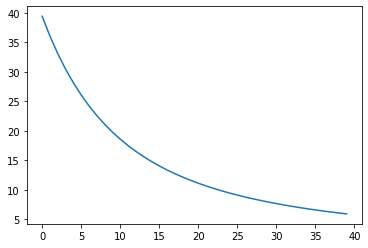

In [8]:
# TensorFlow 2.0 - a more complex example
# step 2 - training but weights are passing from gpu to cpu
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

@tf.function # this decorator tells tf that a graph is defined
def simple_ann_train(x, w1, y):
    y_pred = tf.maximum(tf.matmul(x, w1), 0) # ReLU on logit
    diff = y_pred - y
    loss = tf.reduce_mean(tf.pow(diff, 2))
    grad = tf.gradients(ys=loss, xs=[w1])
    # tf.gradients returns a list of sum(dy/dx) for each x in xs
    return y_pred, loss, grad

np.random.seed(0)
w1 = np.random.randn(D, n_classes)
alpha = 1e-2
J = []
for epoch in range(40):
    with tf.device('/CPU:0'):  # change to /GPU:0 to move it to GPU
        out = simple_ann_train(x_train, w1, y_train)
    y_pred, loss_val, grad = out
    grad_w1 = grad[0] # grad is a list of gradients
    w1 -= alpha * grad_w1.numpy()
    J.append(loss_val)
    print("epoch = {}, loss = {}".format(epoch,loss_val))

plt.plot(J)

epoch = 0, loss = 63.6220454410602
epoch = 1, loss = 58.06371949431109
epoch = 2, loss = 53.185293474860664
epoch = 3, loss = 48.88943560687275
epoch = 4, loss = 45.0937757860741
epoch = 5, loss = 41.72878922175652
epoch = 6, loss = 38.73528930037896
epoch = 7, loss = 36.06319985528618
epoch = 8, loss = 33.66986772155233
epoch = 9, loss = 31.51912880834434
epoch = 10, loss = 29.580165860601273
epoch = 11, loss = 27.826637398359395
epoch = 12, loss = 26.235959279496303
epoch = 13, loss = 24.788813268674016
epoch = 14, loss = 23.46850217448235
epoch = 15, loss = 22.260559074501533
epoch = 16, loss = 21.152498638317336
epoch = 17, loss = 20.133474187174674
epoch = 18, loss = 19.194036918996854
epoch = 19, loss = 18.326033033020934
epoch = 20, loss = 17.522266296236335
epoch = 21, loss = 16.77632304856295
epoch = 22, loss = 16.082675436545586
epoch = 23, loss = 15.436473982552073
epoch = 24, loss = 14.833302114656698
epoch = 25, loss = 14.269344710758034
epoch = 26, loss = 13.7411762945744

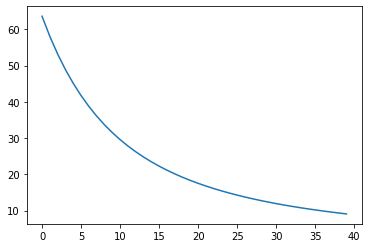

In [9]:
# TensorFlow 2.0 - a more complex example
# step 3 - change weights to persistant in-graph variables
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

@tf.function # this decorator tells tf that a graph is defined
def simple_ann_train(x, y, alpha):
    y_pred = tf.maximum(tf.matmul(x, w1), 0) # ReLU on logit
    diff = y_pred - y
    loss = tf.reduce_mean(tf.pow(diff, 2))
    grad = tf.gradients(ys=loss, xs=[w1])
    # tf.gradients returns a list of sum(dy/dx) for each x in xs
    grad_w1 = grad[0]
    w1.assign(w1 - alpha * grad_w1)
    return y_pred, loss

np.random.seed(0)
alpha = 1e-2
J = []
w1 = tf.Variable(tf.random.normal((D, n_classes), dtype='float64'))
for epoch in range(40):
    with tf.device('/CPU:0'):  # change to /GPU:0 to move it to GPU
        out = simple_ann_train(x_train, y_train, alpha)
    y_pred, loss_val = out
    J.append(loss_val)
    print("epoch = {}, loss = {}".format(epoch,loss_val))

plt.plot(J)

epoch = 0, loss = 81.73814392089844
epoch = 1, loss = 72.59358215332031
epoch = 2, loss = 64.7077407836914
epoch = 3, loss = 57.89655303955078
epoch = 4, loss = 52.00297546386719
epoch = 5, loss = 46.893245697021484
epoch = 6, loss = 42.45335006713867
epoch = 7, loss = 38.58601760864258
epoch = 8, loss = 35.20866394042969
epoch = 9, loss = 32.25084686279297
epoch = 10, loss = 29.65260124206543
epoch = 11, loss = 27.363170623779297
epoch = 12, loss = 25.339311599731445
epoch = 13, loss = 23.54427719116211
epoch = 14, loss = 21.946796417236328
epoch = 15, loss = 20.52029037475586
epoch = 16, loss = 19.242074966430664
epoch = 17, loss = 18.092771530151367
epoch = 18, loss = 17.055879592895508
epoch = 19, loss = 16.11731719970703
epoch = 20, loss = 15.265137672424316
epoch = 21, loss = 14.489046096801758
epoch = 22, loss = 13.780059814453125
epoch = 23, loss = 13.130560874938965
epoch = 24, loss = 12.533862113952637
epoch = 25, loss = 11.984227180480957
epoch = 26, loss = 11.47663116455078

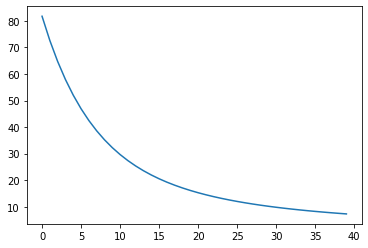

In [10]:
# TensorFlow 2.0 - a more complex example
# step 4 - use pre-defined losses and optimizers
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

@tf.function # this decorator tells tf that a graph is defined
def simple_ann_train(x, y, alpha):
    y_pred = tf.nn.relu(tf.matmul(x, w1))  # ReLU on logit
    mse = tf.keras.losses.MeanSquaredError()
    loss = mse(y, y_pred)
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(1e-2)
    updates = optimizer.minimize(loss, var_list=w1)
    return y_pred, loss

np.random.seed(0)
alpha = 1e-2
J = []
w1 = tf.Variable(tf.random.normal((D, n_classes), dtype='float64'))
for epoch in range(40):
    with tf.device('/CPU:0'):  # change to /GPU:0 to move it to GPU
        out = simple_ann_train(x_train, y_train, alpha)
    y_pred, loss_val = out
    J.append(loss_val)
    print("epoch = {}, loss = {}".format(epoch,loss_val))

plt.plot(J)

### Using pre-defined models with Keras 

In [11]:
# Using Keras
# Single layer network architecture, similar to the one used in the previous steps.
# Full batch SGD
import tensorflow as tf

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(10, input_shape=(D,), use_bias=False, activation='relu'))
model.summary()

sgd = tf.keras.optimizers.SGD(learning_rate=0.5)

model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])

history1 = model.fit(x_train, y_train, batch_size=N, epochs=40)

model.evaluate(x_test,  y_test, verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7840      
Total params: 7,840
Trainable params: 7,840
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples
Epoch 1/40
60000/60000 [==============================] - 2s 37us/sample - loss: 0.1748 - accuracy: 0.0807
Epoch 2/40
60000/60000 [==============================] - 0s 4us/sample - loss: 0.1008 - accuracy: 0.1247
Epoch 3/40
60000/60000 [==============================] - 0s 4us/sample - loss: 0.0998 - accuracy: 0.1357
Epoch 4/40
60000/60000 [==============================] - 0s 4us/sample - loss: 0.0991 - accuracy: 0.1475
Epoch 5/40
60000/60000 [==============================] - 0s 6us/sample - loss: 0.0983 - accuracy: 0.1601
Epoch 6/40
60000/60000 [==============================] - 0s 4us/sample - loss: 0.0975 - accur

[0.06403636519908905, 0.5377]

In [12]:
# Using Keras
# Single layer network architecture, similar to the one used in the previous steps.
# Batch=128 SGD
import tensorflow as tf


model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(10, input_shape=(D,), use_bias=False, activation='relu'))
model.summary()

sgd = tf.keras.optimizers.SGD(learning_rate=0.01)

model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])

history2 = model.fit(x_train, y_train, batch_size=128, epochs=40)

model.evaluate(x_test,  y_test, verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7840      
Total params: 7,840
Trainable params: 7,840
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples
Epoch 1/40
60000/60000 [==============================] - 1s 16us/sample - loss: 0.0981 - accuracy: 0.1732
Epoch 2/40
60000/60000 [==============================] - 1s 12us/sample - loss: 0.0831 - accuracy: 0.2916
Epoch 3/40
60000/60000 [==============================] - 1s 12us/sample - loss: 0.0746 - accuracy: 0.3908
Epoch 4/40
60000/60000 [==============================] - 1s 12us/sample - loss: 0.0682 - accuracy: 0.4592
Epoch 5/40
60000/60000 [==============================] - 1s 12us/sample - loss: 0.0646 - accuracy: 0.4854
Epoch 6/40
60000/60000 [==============================] - 1s 13us/sample - loss: 0.0624 

[0.03737130300402641, 0.7301]

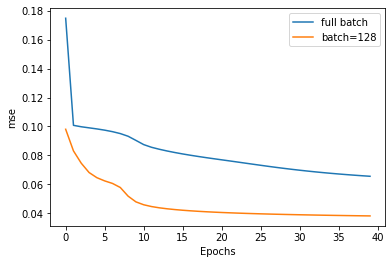

In [13]:
plot_history(history1.epoch, [history1.history['loss'], history2.history['loss']], 
             ['full batch', 'batch=128'], 'mse')